In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import split
from shapely.geometry import box, MultiLineString
from pathlib import Path
import pandas as pd

/home/nialov/.local/share/virtualenvs/trace_repo-280iuCPs/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


In [2]:
import subsampling_config

In [3]:
def remove_invalid_border(line):
    try:
        line.is_simple
        return True
    except Exception:
        return False

Parametrize paths here.

In [4]:
# Geological Survey of Finland Bedrock of Finland 1:200k
bedrock_gdb = "/mnt/d/Data/Bedrock/Bedrock_of_Finland_200k/bedrock_of_finland_200k.gdb"

# Extent of the map we wish to visualize
extent = "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling-simulation-article/data/south_finland_extent.gpkg"

# Digitized geta shoreline
geta_shoreline = "/mnt/f/Users/nikke/Documents/projects/Academic_projects/gtk_ahvenanmaa/sampling-simulation-article/data/shoreline.gpkg"

# World shorelines clipped to our extent
# Will be made if does not already exist.
clipped_shoreline_gpkg_path = Path(
    "/mnt/f/Users/nikke/Documents/projects/"
    "Academic_projects/gtk_ahvenanmaa/"
    "sampling-simulation-article/data/shoreline_GSHHS_f_L1.gpkg"
)

# Database of world shorelines from https://www.ngdc.noaa.gov/mgg/shorelines/
world_shoreline_shp_path = Path(
    "/mnt/d/Data/World/Shoreline/GSHHS_shp/f/GSHHS_f_L1.shp"
)

# Base circle points
base_circle_points_path = "/mnt/d/Data/trace_repo/results/filtered_analysis_points.gpkg"

In [5]:
base_circle_points = gpd.read_file(base_circle_points_path)
polys = []
for idx, row in base_circle_points.iterrows():
    radius = row["radius"]
    geom = row["geometry"]
    poly = geom.buffer(radius)
    polys.append(poly)

base_circles = gpd.GeoDataFrame({"geometry": polys}, crs=base_circle_points.crs)
base_circles.to_file("/mnt/d/Data/trace_repo/results/base_circles.gpkg", driver="GPKG")

In [6]:
bedrock_gdf = gpd.read_file(bedrock_gdb, layer="br200k_lithological_unit")
extent_gdf = gpd.read_file(extent)

In [7]:
geta_shoreline_gdf = gpd.read_file(geta_shoreline)

In [8]:
extent_poly = extent_gdf.geometry.values[0]

In [9]:
bedrock_gdf = bedrock_gdf.loc[bedrock_gdf.intersects(extent_poly)]

In [10]:
if clipped_shoreline_gpkg_path.exists():
    rajat = gpd.read_file(clipped_shoreline_gpkg_path)
else:
    rajat = gpd.read_file(world_shoreline_shp_path, bbox=extent_gdf)
    rajat = rajat.to_crs("EPSG:3067")
    rajat = rajat.loc[[remove_invalid_border(line) for line in rajat.geometry.values]]
    rajat["poly_area"] = rajat.area
    rajat.to_file(clipped_shoreline_gpkg_path, driver="GPKG")

In [11]:
rajat_largest_index = rajat.sort_values(by="poly_area", ascending=False).index[0:400]

In [12]:
aland_geoms_union = bedrock_gdf.loc[bedrock_gdf["SUITE_"] == "Åland rapakivi suite"].unary_union
aland_geoms_union_gdf = gpd.GeoDataFrame({"geometry": [aland_geoms_union], "SUITE_": ["Åland rapakivi suite"]}, crs=bedrock_gdf.crs)

In [13]:
def format_func_m_to_km(value, tick_number):
    return int(value / 1000)

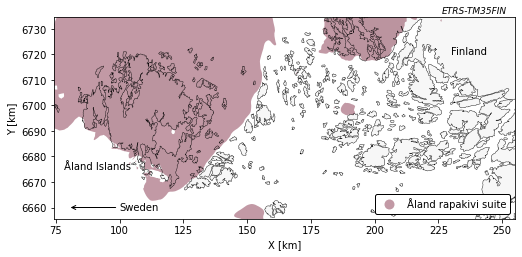

In [14]:
fig, ax = plt.subplots(figsize=(8.27, 12))

# Data to plot

# gdf.plot(column="CHRONOSTRATICRAPHIC_UNIT_", ax=ax, edgecolor="black", linewidth=0, cmap="Greys")
aland_geoms_union_gdf.plot(
    linewidth=0,
    ax=ax,
    alpha=0.4,
    column="SUITE_",
    legend=True,
    cmap="RdBu",
    legend_kwds={"edgecolor": "black", "loc": "lower right", "framealpha": 1},
)
rajat.loc[rajat_largest_index].plot(linewidth=0, ax=ax, color="black", alpha=0.03)
rajat.loc[rajat_largest_index].boundary.plot(linewidth=0.4, ax=ax, color="black")
# geta_shoreline_gdf.plot(ax=ax, color="black")
shoreline_point = (
    MultiLineString(geta_shoreline_gdf.geometry.to_list())
    .representative_point()
    .coords[0]
)

# Plot setup
xmin, ymin, xmax, ymax = extent_poly.bounds
ax.set_xlim(xmin - 5000, xmax)
ax.set_ylim(ymin, ymax)
ax.annotate(
    xy=(80000, 6.66 * 1e6),
    text="Sweden",
    xytext=((100000, 6.66 * 1e6)),
    arrowprops={"arrowstyle": "->"},
    va="center",
)
# ax.annotate(
#     xy=shoreline_point,
#     text="Getaberget Outcrop",
#     xytext=((100000, 6.73 * 1e6)),
#     arrowprops={"arrowstyle": "->"},
#     va="center",
# )
ax.text(230000, 6.72 * 1e6, s="Finland")
ax.text(78000, 6.675 * 1e6, s="Åland Islands")
ax.text(226400, 6.736 * 1e6, s="ETRS-TM35FIN", style="italic", fontsize=9)

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))

ax.set_ylabel("Y [km]")
ax.set_xlabel("X [km]")

fig.set_size_inches(8.27, 6)
fig.savefig(subsampling_config.results_path / "SF_map.svg", bbox_inches="tight")

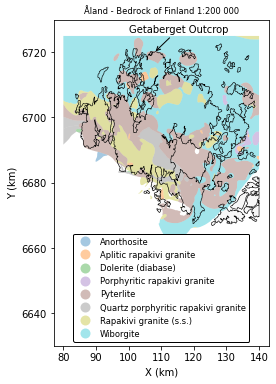

In [15]:
fig, ax = plt.subplots(figsize=(8.27, 6))

clip_box = box(80000, 6.65e6, 140000, 6.725e6)

rajat_clip = gpd.clip(rajat.loc[rajat_largest_index], clip_box)
bedrock_gdf_clip = gpd.clip(bedrock_gdf, clip_box)

rajat_clip.plot(linewidth=0, ax=ax, color="black", alpha=0.03)
rajat_clip.boundary.plot(linewidth=0.6, ax=ax, color="black")
bedrock_gdf_clip.loc[bedrock_gdf_clip["SUITE_"] == "Åland rapakivi suite"].plot(
    linewidth=1,
    ax=ax,
    alpha=0.4,
    column="ROCK_NAME_",
    legend=True,
    legend_kwds={
        "edgecolor": "black",
        "loc": "lower center",
        "framealpha": 1,
        "fontsize": "small",
    },
)
ax.annotate(
    xy=shoreline_point,
    text="Getaberget Outcrop",
    xytext=((100000, 6.727 * 1e6)),
    arrowprops={"arrowstyle": "->"},
    va="center",
)
# ax.set_xlim(70000, 145000)
ax.set_ylim(6.63e6, 6.73e6)
ax.set_title("Åland - Bedrock of Finland 1:200 000", fontsize="small")

ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))
ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func_m_to_km))

ax.set_ylabel("Y (km)")
ax.set_xlabel("X (km)")

fig.savefig("../results/aland_islands_lithology.svg", bbox_inches="tight")